# Create a master frame for plotting anything with seaborn.
Create a file `worm_data_master.csv` that aggregates worm data from all datasets.

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from utils import VALID_DATASETS
from data._utils import load_dataset

In [2]:
all_worm_datasets = [
    load_dataset(dataset)
    for dataset in sorted(VALID_DATASETS, key=lambda x: x[-4:])
    if not dataset.__contains__("sine")
]

new_dict = dict()

for dataset in all_worm_datasets:
    for worm in dataset:
        for neuron, slot in dataset[worm]["neuron_to_slot"].items():
            # get data to fill in table
            dataset_name = dataset[worm]["dataset"]
            smooth_method = dataset[worm]["smooth_method"]
            calcium_data = dataset[worm]["calcium_data"][:, slot].numpy()
            smooth_calcium_data = dataset[worm]["smooth_calcium_data"][:, slot].numpy()
            residual_calcium = dataset[worm]["residual_calcium"][:, slot].numpy()
            smooth_residual_calcium = dataset[worm]["smooth_residual_calcium"][
                :, slot
            ].numpy()
            time_in_seconds = dataset[worm]["time_in_seconds"].squeeze().numpy()
            dt = dataset[worm]["dt"].squeeze().numpy()
            max_timesteps = dataset[worm]["max_timesteps"]
            if neuron in dataset[worm]["named_neuron_to_slot"]:
                is_named_neuron = True
                is_unknown_neuron = False
            elif neuron in dataset[worm]["unknown_neuron_to_slot"]:
                is_named_neuron = False
                is_unknown_neuron = True
            else:
                print("Neither named nor unknown neuron?!?!?!")

            # fill in table
            new_dict.setdefault("dataset", new_dict.get("dataset", [])).append(
                dataset_name
            )
            new_dict.setdefault("worm", new_dict.get("worm", [])).append(worm)
            new_dict.setdefault("neuron", new_dict.get("neuron", [])).append(neuron)
            new_dict.setdefault("slot", new_dict.get("slot", [])).append(slot)
            new_dict.setdefault(
                "is_named_neuron", new_dict.get("is_named_neuron", [])
            ).append(is_named_neuron)
            new_dict.setdefault(
                "is_unknown_neuron", new_dict.get("is_unknown_neuron", [])
            ).append(is_unknown_neuron)
            new_dict.setdefault(
                "calcium_data", new_dict.get("calcium_data", [])
            ).append(calcium_data)
            new_dict.setdefault(
                "smooth_calcium_data", new_dict.get("smooth_calcium_data", [])
            ).append(smooth_calcium_data)
            new_dict.setdefault(
                "residual_calcium", new_dict.get("residual_calcium", [])
            ).append(residual_calcium)
            new_dict.setdefault(
                "smooth_residual_calcium", new_dict.get("smooth_residual_calcium", [])
            ).append(smooth_residual_calcium)
            new_dict.setdefault(
                "smooth_method", new_dict.get("smooth_method", [])
            ).append(smooth_method)
            new_dict.setdefault(
                "time_in_seconds", new_dict.get("time_in_seconds", [])
            ).append(time_in_seconds)
            new_dict.setdefault("dt", new_dict.get("dt", [])).append(dt)
            new_dict.setdefault(
                "max_timesteps", new_dict.get("max_timesteps", [])
            ).append(max_timesteps)

df_short = pd.DataFrame.from_dict(new_dict)

# # Save to a CSV file
# pd.DataFrame.to_csv(df_short, "../data/worm_data_short.csv")

# Display the dataframe
df_short

,dataset,worm,neuron,slot,is_named_neuron,is_unknown_neuron,calcium_data,smooth_calcium_data,residual_calcium,smooth_residual_calcium,smooth_method,time_in_seconds,dt,max_timesteps
0,Kato2015,worm0,ADAL,0,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
1,Kato2015,worm0,ADAR,1,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
2,Kato2015,worm0,ADEL,2,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
3,Kato2015,worm0,ADER,3,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
4,Kato2015,worm0,ADFL,4,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46503,Flavell2023,worm9,VD5,297,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.5996094, 1.2011719, 1.8007812, 2.38476...","[0.0, 0.5996094, 0.6015625, 0.5996094, 0.58398...",1600
46504,Flavell2023,worm9,VD6,298,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.5996094, 1.2011719, 1.8007812, 2.38476...","[0.0, 0.5996094, 0.6015625, 0.5996094, 0.58398...",1600
46505,Flavell2023,worm9,VD7,299,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.5996094, 1.2011719, 1.8007812, 2.38476...","[0.0, 0.5996094, 0.6015625, 0.5996094, 0.58398...",1600
46506,Flavell2023,worm9,VD8,300,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.5996094, 1.2011719, 1.8007812, 2.38476...","[0.0, 0.5996094, 0.6015625, 0.5996094, 0.58398...",1600


This DataFrame `df_short` seems to contain information on neuronal calcium activity of a worm dataset. The columns are as follows:
1. `dataset`: The dataset identifier, in this case "Kato2015".
2. `worm` : Worm identifier, e.g. "worm0".
3. `neuron`: Neuron identifier, either a named neuron like "ADAL" or an integer index for unnamed neurons.
4. `slot`: An integer index representing the position of the neuron in the dataset.
5. `is_named_neuron`: A boolean indicating if the neuron has a specific name (True) or is indexed by an integer (False).
6. `is_unknown_neuron`: A boolean indicating if the neuron is unknown (True) or not (False).
7. `calcium_data`: A list of raw calcium activity values for the neuron.
8. `smooth_calcium_data`: A list of smoothed calcium activity values for the neuron.
9. `residual_calcium`: A list of residual calcium values for the neuron.
10. `smooth_residual_calcium`: A list of smoothed residual calcium values for the neuron.
11. `smooth_method`: The method used for smoothing the calcium data, in this case, "FFT" (Fast Fourier Transform).
12. `time_in_seconds`: A list of time points in seconds corresponding to the calcium data.
13. `dt`: A list of time differences between consecutive time points in seconds.
14. `max_timesteps`: The maximum number of timesteps for the calcium data, in this case, 2198.

Yes, you can restructure your DataFrame to make it more suitable for visualization using seaborn. One common format that seaborn works well with is the "long format" or "tidy format". In this format, each row represents a single observation, and each column represents a variable.

Here's a suggestion on how to restructure your DataFrame:

1. Create a new DataFrame with only the columns you need for visualization. In this case, let's keep `dataset`, `worm`, `neuron`, `is_named_neuron`, `is_unknown_neuron`, `time_in_seconds`, and `smooth_calcium_data`.

2. Convert the `time_in_seconds` and `smooth_calcium_data` columns, which are lists, into multiple rows with one value per row.

Here's a code example for restructuring the DataFrame:

In [3]:
# Keep only relevant columns
df_visualization = df_short[
    [
        "dataset",
        "worm",
        "neuron",
        "is_named_neuron",
        "is_unknown_neuron",
        "time_in_seconds",
        "calcium_data",
        "smooth_calcium_data",
        "residual_calcium",
        "smooth_residual_calcium",
    ]
]

# Create an empty list to store DataFrames
df_list = []

# Loop through the rows of the DataFrame
for _, row in df_visualization.iterrows():
    # Create a temporary DataFrame for each row
    temp_df = pd.DataFrame(
        {
            "time_in_seconds": row["time_in_seconds"],
            "calcium_data": row["calcium_data"],
            "smooth_calcium_data": row["smooth_calcium_data"],
            "residual_calcium": row["residual_calcium"],
            "smooth_residual_calcium": row["smooth_residual_calcium"],
        }
    )

    # Add constant columns
    temp_df["dataset"] = row["dataset"]
    temp_df["worm"] = row["worm"]
    temp_df["neuron"] = row["neuron"]
    temp_df["is_named_neuron"] = row["is_named_neuron"]
    temp_df["is_unknown_neuron"] = row["is_unknown_neuron"]

    # Append the temporary DataFrame to the list
    df_list.append(temp_df)

# Concatenate all the temporary DataFrames into one
df_long = pd.concat(df_list, ignore_index=True)

# # Save to a CSV file -- too largge to save!
# pd.DataFrame.to_csv(df_long, "../data/worm_data_long.csv")

# Display the dataframe
df_long

,time_in_seconds,calcium_data,smooth_calcium_data,residual_calcium,smooth_residual_calcium,dataset,worm,neuron,is_named_neuron,is_unknown_neuron
0,0.000000,0.000000,0.000000,0.000000,0.000000,Kato2015,worm0,ADAL,True,False
1,0.327571,0.000000,0.000000,0.000000,0.000000,Kato2015,worm0,ADAL,True,False
2,0.655141,0.000000,0.000000,0.000000,0.000000,Kato2015,worm0,ADAL,True,False
3,0.982712,0.000000,0.000000,0.000000,0.000000,Kato2015,worm0,ADAL,True,False
4,1.310282,0.000000,0.000000,0.000000,0.000000,Kato2015,worm0,ADAL,True,False
...,...,...,...,...,...,...,...,...,...,...
158586235,959.505859,-0.542705,-0.661016,-0.026299,-0.000431,Flavell2023,worm9,41,False,True
158586236,960.095703,-0.569924,-0.656135,-0.027219,0.004881,Flavell2023,worm9,41,False,True
158586237,960.726562,-0.598112,-0.644343,-0.028187,0.011792,Flavell2023,worm9,41,False,True
158586238,961.330078,-0.597993,-0.623980,0.000118,0.020364,Flavell2023,worm9,41,False,True


Yes, you are correct. The `df_long` format is better suited for plotting using seaborn because seaborn works well with long-format data. This format allows you to easily create complex plots, and seaborn takes care of grouping, aggregating, and transforming data for the desired visualizations. This is because seaborn functions typically expect data in a tidy long-format data structure, where each row is an observation and columns contain the variables.

You can use seaborn's lineplot function to create a plot of calcium data for all instances of a particular neuron (e.g., ADAL) against its corresponding time vector. 

This code will create a plot of calcium data for all instances of the ADAL neuron against its corresponding time vector, with each worm represented by a different color. 

You can replace `ADAL` with any other neuron name to plot the data for that neuron.

['worm31' 'worm30' 'worm40' 'worm14' 'worm12' 'worm42' 'worm8' 'worm11'
 'worm3' 'worm15' 'worm41' 'worm13' 'worm20' 'worm2' 'worm17' 'worm24'
 'worm9' 'worm5' 'worm34' 'worm16' 'worm4' 'worm10']


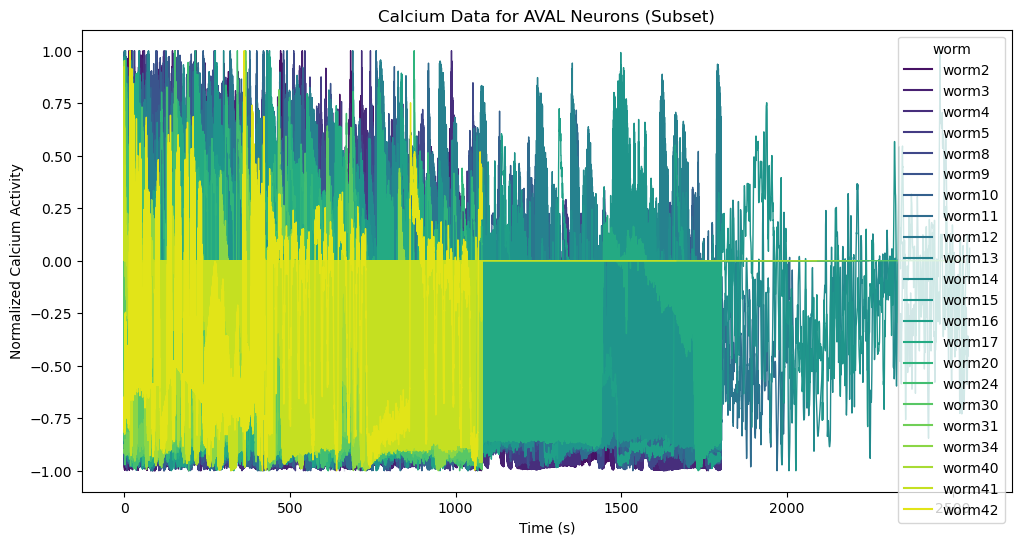

In [4]:
# Filter the DataFrame for the neuron of interest
neuron_of_interest = "AVAL"
dataset_of_interest = "Flavell2023"
condition = df_long["neuron"] == neuron_of_interest
# condition = (df_long["neuron"] == neuron_of_interest) & (
#     df_long["dataset"] == dataset_of_interest
# )
df_neuron = df_long[condition]

# Filter out worms with zero calcium data
df_neuron = df_neuron.groupby("worm").filter(
    lambda x: not np.all(x["calcium_data"] == 0)
)

# Get unique worm identifiers
unique_worms = df_neuron["worm"].unique()

# Create a random subset of the worms
random_worms = np.random.choice(
    unique_worms, size=len(unique_worms) // 4, replace=False
)
print(random_worms)

# Filter the DataFrame for the selected worms
df_neuron_subset = df_neuron[df_neuron["worm"].isin(random_worms)]

# Create the lineplot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_neuron_subset,
    x="time_in_seconds",
    y="calcium_data",
    hue="worm",
    palette="viridis",
    linewidth=1,
)

# Customize the plot
plt.title(f"Calcium Data for {neuron_of_interest} Neurons (Subset)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Calcium Activity")

# Show the plot
plt.show()

Some helper functions for later on:

In [7]:
def interpolate_data(time, data, target_dt):
    """
    Interpolate data using np.interp, with support for torch.Tensor inputs.

    Parameters:
    time (torch.Tensor): A 1D tensor containing the time points corresponding to the data.
    data (torch.Tensor): A 2D tensor containing the data to be interpolated, with shape (time, neurons).
    target_dt (float): The desired time interval between the interpolated data points.

    Returns:
    torch.Tensor, torch.Tensor: Two tensors containing the interpolated time points and data.
    """
    # If target_dt is None, return the original data
    if target_dt is None:
        return time, data

    # Convert input tensors to NumPy arrays
    time_np = time.squeeze().numpy()
    data_np = data.numpy()

    # Interpolate the data
    target_time_np = np.arange(time_np.min(), time_np.max(), target_dt)
    num_neurons = data_np.shape[1]
    interpolated_data_np = np.zeros((len(target_time_np), num_neurons))

    for i in range(num_neurons):
        interpolated_data_np[:, i] = np.interp(target_time_np, time_np, data_np[:, i])

    # Convert the interpolated data and time back to torch.Tensor objects
    target_time = torch.from_numpy(target_time_np)
    interpolated_data = torch.from_numpy(interpolated_data_np)

    return target_time, interpolated_data


def plot_frequency_distribution(data, ax, title, dt=1.0):
    # Compute the FFT and frequencies
    fft_data = torch.fft.rfft(torch.tensor(data))
    freqs = torch.fft.rfftfreq(len(data), d=dt)

    # Plot the frequency distribution
    ax.plot(freqs, torch.abs(fft_data))
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)


# Define a function to calculate the confidence interval
def bootstrap_ci(data, num_bootstraps=1000, alpha=0.05):
    bootstrapped_means = np.empty(num_bootstraps)
    for i in range(num_bootstraps):
        resampled_data = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means[i] = np.mean(resampled_data)
    lower_bound = np.percentile(bootstrapped_means, alpha * 100 / 2)
    upper_bound = np.percentile(bootstrapped_means, 100 - alpha * 100 / 2)
    return lower_bound, upper_bound

To use the `interpolate_data` function to create a new DataFrame with resampled time series, you can follow these steps:
1. Group the original DataFrame by 'worm' and 'neuron'.
2. Apply the "interpolate_data' function to each group.
3. Create a new DataFrame from the interpolated data.
Here's a code snippet that demonstrates these steps:

In [8]:
import pandas as pd

# Define the target_dt you want to resample the time series
DT = 0.25
target_dt = DT

# Group the original DataFrame by 'worm' and 'neuron'
grouped = df_long.groupby(["worm", "neuron"])


# Function to apply to each group
def interpolate_group(group):
    time = torch.tensor(group["time_in_seconds"].values, dtype=torch.float64)
    data = torch.tensor(group["calcium_data"].values, dtype=torch.float64).unsqueeze(1)
    target_time, interpolated_data = interpolate_data(time, data, target_dt)

    interpolated_data = pd.DataFrame(
        {
            "time_in_seconds": target_time.numpy(),
            "calcium_data": interpolated_data.numpy().flatten(),
        }
    )
    interpolated_data["worm"] = group["worm"].iloc[0]
    interpolated_data["neuron"] = group["neuron"].iloc[0]

    return interpolated_data


# Apply the interpolate_group function to each group and concatenate the results into a new DataFrame
df_interpolated = pd.concat(
    [interpolate_group(group) for _, group in grouped], ignore_index=True
)

# Show the new DataFrame
df_interpolated

,time_in_seconds,calcium_data,worm,neuron
0,0.00,0.603766,worm0,0
1,0.25,0.277184,worm0,0
2,0.50,0.552582,worm0,0
3,0.75,0.690041,worm0,0
4,1.00,0.198094,worm0,0
...,...,...,...,...
142063015,1895.75,0.000000,worm9,VD9
142063016,1896.00,0.000000,worm9,VD9
142063017,1896.25,0.000000,worm9,VD9
142063018,1896.50,0.000000,worm9,VD9


In [9]:
def plot_neuron_frequency_distributions(
    neuron_name,
    df_original,
    df_interpolated,
):
    instances = df_original[df_original["neuron"] == neuron_name]["worm"].unique()
    n_instances = len(instances)

    fig, axes = plt.subplots(
        n_instances, 3, figsize=(20, 5 * n_instances), sharex="col"
    )

    for i, worm in enumerate(instances):
        original_data = df_original[
            (df_original["neuron"] == neuron_name) & (df_original["worm"] == worm)
        ]["calcium_data"].values
        resampled_data = df_interpolated[
            (df_interpolated["neuron"] == neuron_name)
            & (df_interpolated["worm"] == worm)
        ]["calcium_data"].values

        if len(original_data) == 0 or len(resampled_data) == 0:
            continue

        # FFT histograms of original and resampled data
        plot_frequency_distribution(
            original_data, axes[i, 0], f"{worm} - Original Data"
        )
        plot_frequency_distribution(
            resampled_data, axes[i, 1], f"{worm} - Resampled Data"
        )

        # Difference in FFT histograms
        n = min(len(original_data), len(resampled_data))
        fft_original = torch.fft.rfft(torch.tensor(original_data[:n]))
        fft_resampled = torch.fft.rfft(torch.tensor(resampled_data[:n]))
        diff_fft = torch.abs(fft_original) - torch.abs(fft_resampled)

        # Plot the histogram of the difference
        n, bins, patches = axes[i, 2].hist(
            diff_fft.numpy(), bins=50, density=True, alpha=0.6, color="g"
        )

        # Fit a normal distribution to the difference
        mu, std = stats.norm.fit(diff_fft.numpy())
        epsilon = 1e-8
        p = stats.norm.pdf(bins, mu, std + epsilon)
        axes[i, 2].plot(bins, p, "k", linewidth=2)

        # Compute the bootstrap 95% confidence interval for the mean of the difference
        ci_lower, ci_upper = bootstrap_ci(diff_fft.numpy())

        # Add the confidence interval to the plot
        axes[i, 2].axvline(ci_lower, color="red", linestyle="dashed", linewidth=2)
        axes[i, 2].axvline(ci_upper, color="red", linestyle="dashed", linewidth=2)

        axes[i, 2].set_title(f"{worm} - Difference Histogram")
        axes[i, 2].set_xlabel("Difference")
        axes[i, 2].set_ylabel("Frequency")

        # Add the mean and confidence interval as an annotation
        mean_text = f"Mean: {mu:.4f}"
        ci_text = f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]"
        axes[i, 2].text(
            0.05,
            0.95,
            f"{mean_text}\n{ci_text}",
            transform=axes[i, 2].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        )
        if i > 2:
            break
    plt.tight_layout()
    plt.show()

In [10]:
plot_neuron_frequency_distributions("AVAL", df_long, df_interpolated)

In [ ]:
# pd.DataFrame.to_csv(new_df, "../data/worm_data_long.csv")

In [ ]:
# sns.lineplot(x="time_in_seconds", y="calcium_data", data=df.iloc[46507])
# sns.lineplot(x="time_in_seconds", y="calcium_data", data=df.iloc[46506])
# sns.lineplot(x="time_in_seconds", y="calcium_data", data=df.iloc[46505])